```text
SPDX-License-Identifier: PolyForm-Noncommercial-1.0.0
Autor: Bruno Francisco Barra Atarama
Institución:
  Departamento de Ingeniería Aeroespacial
  Facultad de Ingeniería
  Universidad Nacional de La Plata
Año: 2025
Licencia: PolyForm Noncommercial License 1.0.0
```

**Licencia:** ver [LICENSE](../LICENSE).

# Test de validación: NACA TN 2465

No se considera a este *notebook* netamente como un ejemplo, ya que no necesariamente clarifica el uso del simulador.

Esto no quita que los ejemplos [base](ejemploBase.ipynb) y el [ala con flap](ejemploAlaFlap.ipynb) puedan ser considerados instancias de evaluación del método.

Sin más, en esta ocasión se configurará un conjunto de dos sólidos para simular los experimentos de un perfil simétrico con movimientos armónicos de rotación y traslación vertical como los del [NACA Technical Note no. 2465 (19930083191)](https://ntrs.nasa.gov/citations/19930083191).

## Bibliotecas y módulos

A continuación, se muestra qué bibliotecas se importan para este test.

El módulo de tipado se recomienda utilizar para aprovechar las ayudas documentadas, sobre todo en los primeros usos.

In [1]:
%matplotlib inline
# Para gráficos interactivos en el notebook. # Para utilizar, instalar ipympl con `pip install ipympl`
# %matplotlib widget    

# Bibliotecas generales
import numpy as np                  # Para hacer operaciones matemáticas
import matplotlib, matplotlib.pyplot as plt     # Para graficar

# Módulos propios

# Funcionales
from src.MP2D import MP2D
from src import Cinematicas
from src.Importacion import discretizarPerfil

# Tipado
from src import Tipos

# Datos y funciones auxliares
from Ejemplos.rec.NACATN2465.NACATN2465 import theodorsenRotacion, theodorsenTraslacion
from Ejemplos.rec.NACATN2465.NACATN2465 import analisisSenalSenoidal, plotTeoricoExperimental

## Configuración general

En los experimentos se evalúan diferentes velocidades reducidas $k = \frac{\omega b}{V}$ (donde $\omega$ es la frecuencia angular, $b$ la semicuerda y $V$ la velocidad de la corriente libre) y diferentes amplitudes, con lo cual eso deberá ser definido para cada experimento.

En el siguiente bloque, se definirán parámetros generales, como la cuerda, como el perfil discretizado, el paso angular (ya no temporal, para mantener la escala cada experimento particular), la duración de los experimentos en periodos y otros.

Se nota, además que se desplaza el perfil para ubicar su eje de rotación (que también es el eje de toma de momentos) en el origen. En el experimento de traslación esto no tiene efecto.

In [2]:
c = 1 * 0.3048          # Cuerda
b = c / 2               # Semicuerda
c_rot = 0.37 * c        # Distancia del eje del BA al eje de rotación
V = 100 * 0.44704    # Velocidad de la corriente libre

# Perfil
nIntraExtra = 150   # Paneles por intradós y por extradós (el total de paneles sería el doble)

r_xy = discretizarPerfil(
    ruta='rec/perfiles/NACA0012_selig.txt',
    nIntrados=nIntraExtra,
    nExtrados=nIntraExtra,
    formato='selig',
    cuerda=c,
    espaciamiento='cos'
)

# Configuración estacionario
AOAParams: Tipos.AOAParams = {'alfa' : [5], 'r_xy' : r_xy, 'V' : V}
cinematica = Cinematicas.cinematica('aoa', AOAParams)

# Configuradores del simulador
refConfig: Tipos.RefConfig = {'V' : V, 'l' : c,}
mpConfig: Tipos.MPConfig = {'estacionario': True, 'vorticeArranque' : True}

# Simulación
mp = MP2D(cinematica, mpConfig=mpConfig, refConfig=refConfig)
mp.simular()
print(f'Cl estacionario MP / Cl estacionario teórico: {mp.CxyTotalRec[0][1]/np.deg2rad(5)/2/np.pi}')
print(f'Relaciones adimensionales calculadas:\n{mp.adimInfo}')

Simulando: 100%|██████████| 1/1 [00:00<00:00, 66.65 pasos/s]

Cl estacionario MP / Cl estacionario teórico: 1.0894531275051698
Relaciones adimensionales calculadas:
{'Re': 908385.28, 'Ma': 0.13136644137525713, 'Fr': 25.852610281668017, '_Re': 1.1008544744362215e-06, '_Fr2': 0.001496205342617297, 'Ma2': 0.01725714191959887, 'Ma2_Re': 1.8997601898171302e-08, 'Ma2_Fr2': 2.5820227938408745e-05}


In [3]:
k = np.linspace(1e-5, 0.6, 30)  # Frecuencias reducidas teóricas
kSim = np.array([0.05, 0.15, 0.25, 0.35, 0.45]) # Frecuencias reducidas simuladas

wDt = 0.1          # Producto velocidad angular * paso de tiempo. Es el paso angular

periodos = 30

r_xy = Cinematicas.moverCoordenadas(r_xy, Dx=-c_rot)    # Se desplaza el perfil para ubicar el origen en el centro de rotación.

# Configuradores del simulador
refConfig: Tipos.RefConfig = {'V' : V, 'l' : c,}
mpConfig: Tipos.MPConfig = {'estacionario': False, 'rigidez' : 1, 'vorticeArranque' : True}

## Experimentos

A continuación, se definen dos funciones, una para cada tipo de movimiento armónico, para poder automatizar la realización de las distintas simulaciones.

In [4]:
from copy import deepcopy
def simulacionRotacion(kk, a0, SELInfo=False):
    # Listas que almacenarán el módulo y la fase, tanto de la sustantación como el momento
    mod_L = []
    fase_L = []

    mod_M = []
    fase_M = []

    # Simulación por cada frecuencia reducida
    for k in kk:
        # Configuración de la simulación a partir de las variables generlas, y simulación
        w = k * V / b

        Dt = wDt / w

        T = 2 * np.pi / w
        tFinal = periodos * T

        t = np.arange(0, tFinal, Dt)

        params: Tipos.RotacionArmonicaParams = {
            't' : t,
            'r_xy': r_xy,
            'a0': a0,
            'V': V,
            'w': w,
        }

        if SELInfo:
            mpConfig['SELInfo'] = True 

        cinematica = Cinematicas.cinematica('rotacionArmonica', params)
        RM = Cinematicas.RM('desdeCinematicaRO', {'cinematica' : Cinematicas.cinematica('rotacionArmonica', params)})

        mp = MP2D(cinematica, RM, mpConfig=mpConfig, refConfig=refConfig)

        mp.simular()
        
        if SELInfo:
            mpConfig['SELInfo'] = False

        # Calculo de fuerza y momento
        Cy = np.array([Cxy[1] for Cxy in mp.CxyTotalRec])
        L = - Cy * mp.refConfig['Q'] * mp.refConfig['l']    # Signo menos por definición del NACA 2465
        L_4qb = L / 4 / mp.refConfig['Q'] / b 
        
        Cm = np.array(mp.CmTotalRec)
        M = Cm * mp.refConfig['Q'] * mp.refConfig['l'] ** 2
        M_4qb2 = M / 4 / mp.refConfig['Q'] / b ** 2

        # Obtención de la amplitud y fase de la señal
        amplitud, fase, periodo = analisisSenalSenoidal(mp.t, L_4qb)
        mod_L.append(amplitud)
        fase_L.append(fase)

        amplitud, fase, periodo = analisisSenalSenoidal(mp.t, M_4qb2)
        mod_M.append(amplitud)
        fase_M.append(fase)

    L = (kk, np.array(mod_L), np.array(fase_L))
    M = (kk, np.array(mod_M), np.array(fase_M))
    return L, M, mp

def simulacionTraslacion(kk, h0):
    # Listas que almacenarán el módulo y la fase, tanto de la sustantación como el momento
    mod_L = []
    fase_L = []

    mod_M = []
    fase_M = []

    # Simulación por cada frecuencia reducida
    for k in kk:
        # Configuración de la simulación a partir de las variables generlas, y simulación
        w = k * V / b

        Dt = wDt / w

        T = 2 * np.pi / w
        tFinal = periodos * T

        t = np.arange(0, tFinal, Dt)

        params: Cinematicas.TraslacionArmonicaParams = {
            't' : t,
            'r_xy': r_xy,
            'h0': h0,
            'V': V,
            'w': w,
        }

        cinematica = Cinematicas.cinematica('traslacionArmonica', params)
        RM = Cinematicas.RM('desdeCinematicaRO', {'cinematica' : Cinematicas.cinematica('traslacionArmonica', params)})

        mp = MP2D(cinematica, RM, mpConfig=mpConfig, refConfig=refConfig)

        mp.simular()

        # Calculo de fuerza y momento
        Cy = np.array([Cxy[1] for Cxy in mp.CxyTotalRec])
        L = - Cy * mp.refConfig['Q'] * mp.refConfig['l']    # Signo menos por definición del NACA 2465
        L_4qb = L / 4 / mp.refConfig['Q'] / b 
        
        Cm = np.array(mp.CmTotalRec)
        M = Cm * mp.refConfig['Q'] * mp.refConfig['l'] ** 2
        M_4qb2 = M / 4 / mp.refConfig['Q'] / b ** 2

        # Obtención de la amplitud y fase de la señal
        amplitud, fase, periodo = analisisSenalSenoidal(mp.t, L_4qb)
        mod_L.append(amplitud)
        fase_L.append(fase)

        amplitud, fase, periodo = analisisSenalSenoidal(mp.t, M_4qb2)
        mod_M.append(amplitud)
        fase_M.append(fase)
        
    L = (kk, np.array(mod_L), np.array(fase_L))
    M = (kk, np.array(mod_M), np.array(fase_M))
    return L, M, mp

## Visualización de uno de los experimentos

En este bloque se muestra el desarrollo de la estela, el $C_d$, el $C_l$ y el $C_{m,0.37c}$ de uno de los experimentos de movimiento armónico de rotación.

In [5]:
a0 = 6.74
k0 = 0.5
_, _, mp = simulacionRotacion([k0], a0)

Simulando: 100%|██████████| 1885/1885 [05:59<00:00,  5.24 pasos/s]


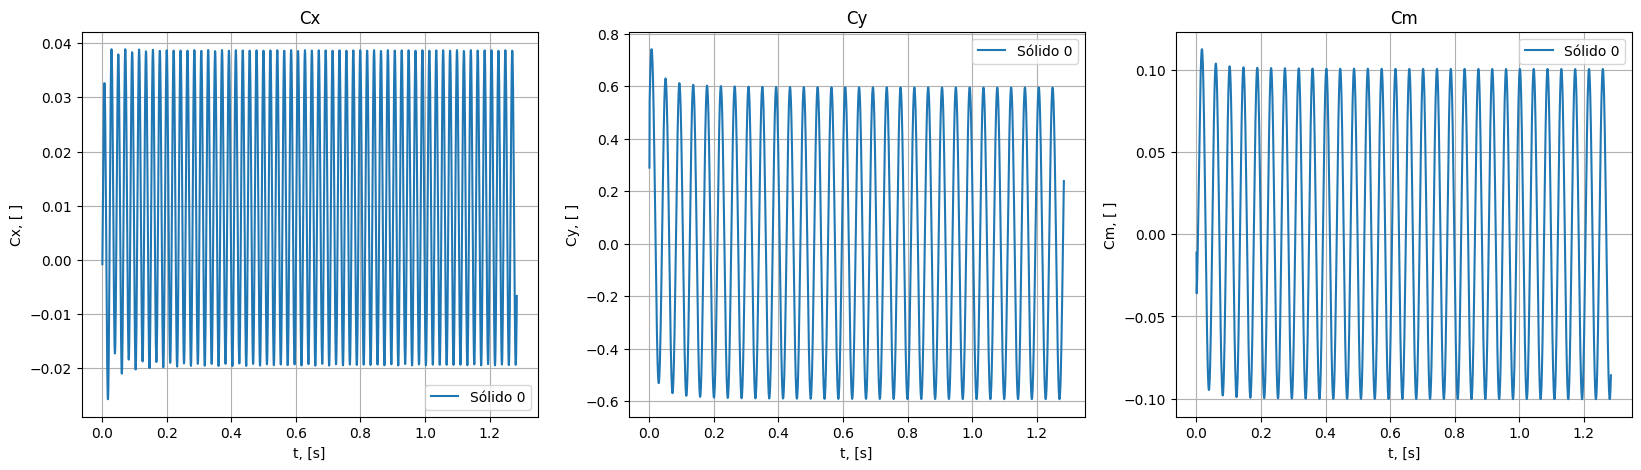

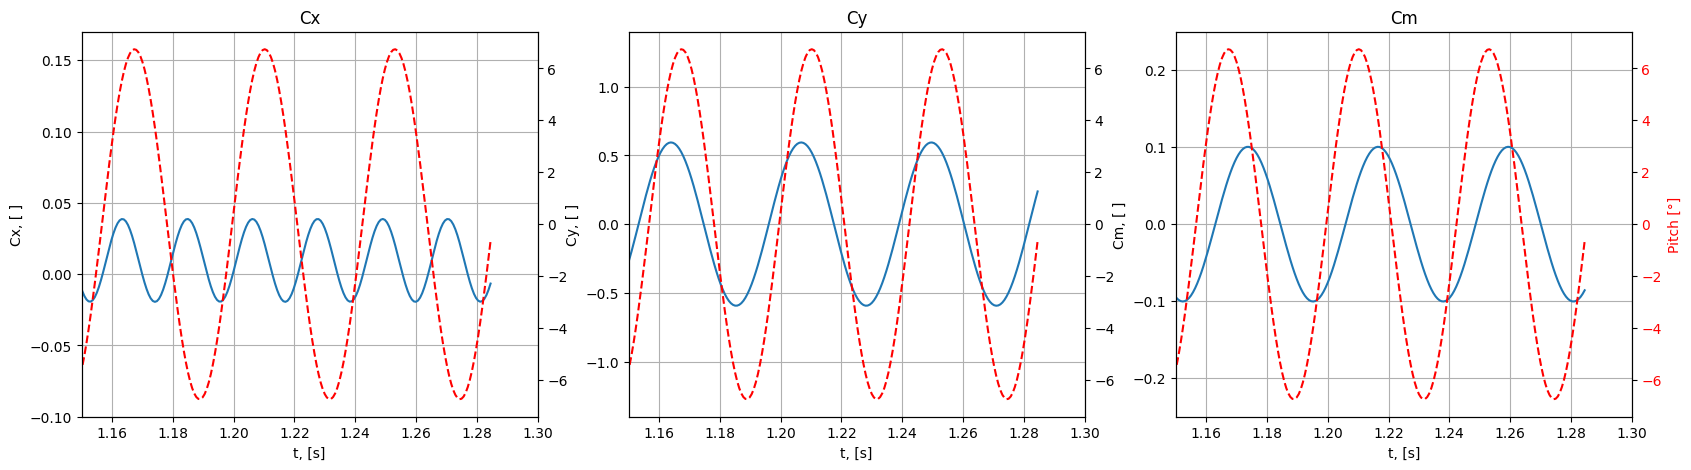

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
mp.plotCAero(ax=ax)

fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
mp.plotCAero(ax=ax)
ax[0].set_xlim((1.15, 1.3))

ax[0].set_ylim((-0.1, 0.17))
ax[1].set_ylim((-1.4, 1.4))
ax[2].set_ylim((-0.25, 0.25))

w = k0 * V / b
theta = a0 * np.sin(w * np.array(mp.t))

ax2 = ax[0].twinx()
ax2.plot(mp.t, theta, 'r--')
ax2 = ax[1].twinx()
ax2.plot(mp.t, theta, 'r--')
ax2 = ax[2].twinx()
ax2.plot(mp.t, theta, 'r--')


ax2.set_ylabel("Pitch [°]", color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax[0].legend().remove(), ax[1].legend().remove(), ax[2].legend().remove()
plt.show()

A continuación se grafican las variaciones relativas de los picos de cada semiciclo para evaluar el establecimiento de las respuestas.

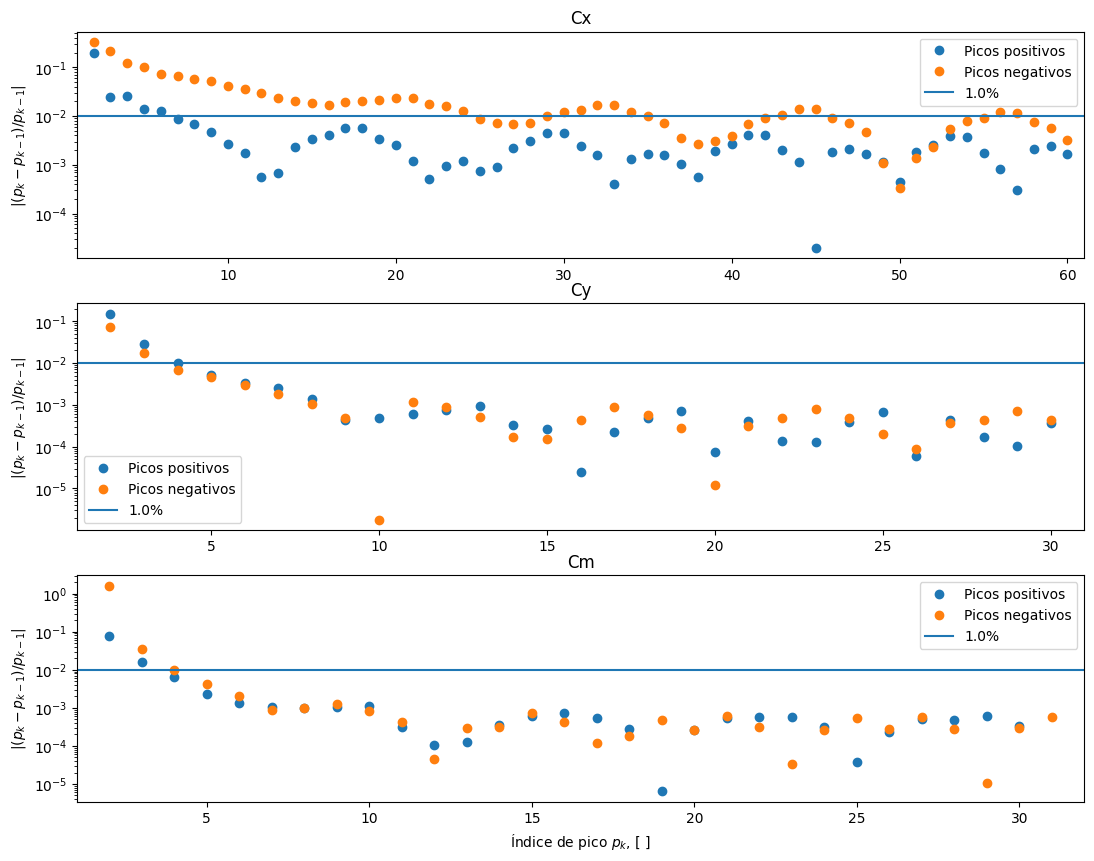

In [7]:
from scipy.signal import find_peaks

def picoVariacionRelativa(C, ax: plt.Axes, yCorte=None):
    picosPos, _ = find_peaks(C)
    picosPos = C[picosPos]
    rPos = np.abs((picosPos[1:] - picosPos[:-1]) / picosPos[:-1])
    iPos = np.arange(len(rPos)) + 2

    CNeg = -C
    picosNeg, _ = find_peaks(CNeg)
    picosNeg = C[picosNeg]
    rNeg = np.abs((picosNeg[1:] - picosNeg[:-1]) / picosNeg[:-1])
    iNeg = np.arange(len(rNeg)) + 2

    ax.semilogy(iPos, rPos, 'o', label='Picos positivos')
    ax.semilogy(iNeg, rNeg, 'o', label='Picos negativos')
    
    if yCorte is not None:
        ax.axhline(yCorte, label=f'{yCorte * 100}%')

    ax.set_xlim(1, np.max([iPos[-1], iNeg[-1]]) + 1)
    ax.legend()
    ax.set_ylabel(r'$|(p_k - p_{k-1})/p_{k-1}|$')
    return ax

Cx = np.asarray([Cxy[0] for Cxy in mp.CxyTotalRec])
Cy = np.asarray([Cxy[1] for Cxy in mp.CxyTotalRec])
Cm = np.asarray(mp.CmTotalRec)

fig, ax = plt.subplots(3, 1, figsize=(13, 10))

r = 0.01
picoVariacionRelativa(Cx, ax[0], r)
picoVariacionRelativa(Cy, ax[1], r)
picoVariacionRelativa(Cm, ax[2], r)
ax[0].set_title('Cx')
ax[1].set_title('Cy')
ax[2].set_title('Cm')

ax[2].set_xlabel(r'Índice de pico $p_k$, [ ]')
plt.show()

Como se puede ver, al inicio del experimento existen transitorios y posteriormente las respuestas del $C_l$ y $C_m$ son senoidales con media nula, mientras que $C_d$ es una señal con el doble de la frecuencia que la entrada y media positiva. Esto coincide con los datos experimentales (en los que además ocurren efectos viscosos) y la teoría potencial.

En el detalle de los últimos periodos, se puede ver que para el número de periodos elegido, las señales de $C_l$ y $C_m$ ya son simétricas respecto del $0$ reforzando el hecho de que se estableció el régimen permanente.

A continuación, se realiza el mismo experimento con la única diferencia de que la amplitud de la entrada ahora es de la mitad.

Simulando: 100%|██████████| 1885/1885 [06:27<00:00,  4.87 pasos/s]


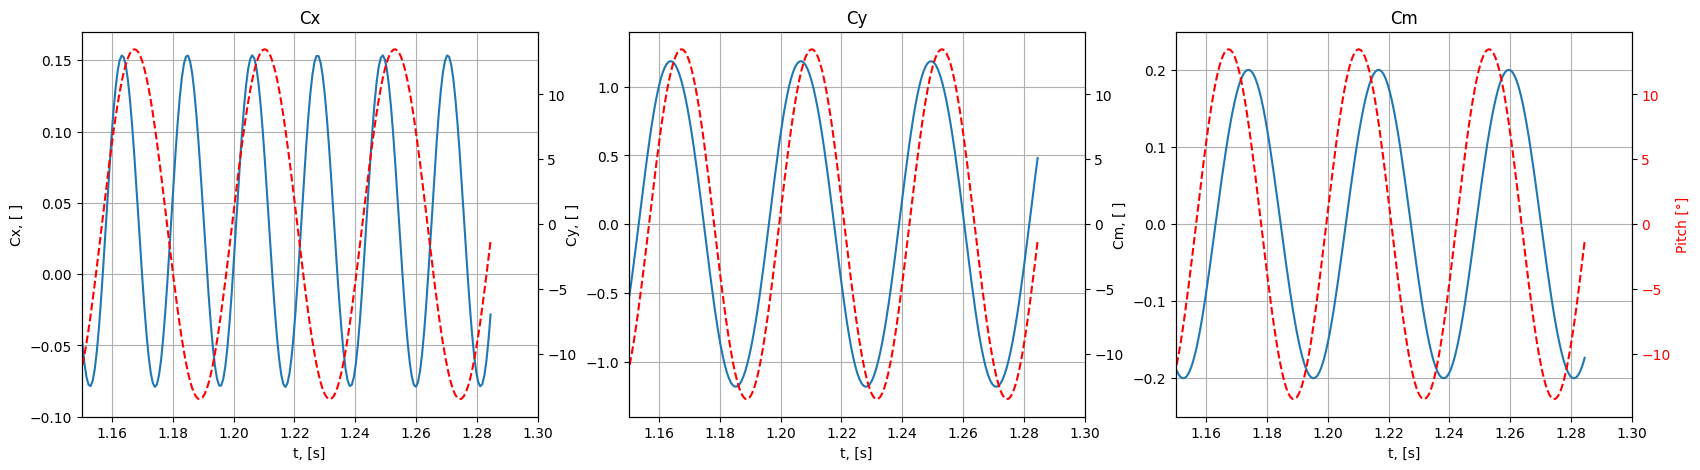

In [8]:
a0 = 6.74 * 2
_, _, mp = simulacionRotacion([k0], a0, SELInfo=True)

mp.guardar('rec/animación/mp_rotación_1348_05') # Se guarda la simulación para generar la animación

fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
mp.plotCAero(ax=ax)
ax[0].set_xlim((1.15, 1.3))

ax[0].set_ylim((-0.1, 0.17))
ax[1].set_ylim((-1.4, 1.4))
ax[2].set_ylim((-0.25, 0.25))

w = k0 * V / b
theta = a0 * np.sin(w * np.array(mp.t))

ax2 = ax[0].twinx()
ax2.plot(mp.t, theta, 'r--')
ax2 = ax[1].twinx()
ax2.plot(mp.t, theta, 'r--')
ax2 = ax[2].twinx()
ax2.plot(mp.t, theta, 'r--')


ax2.set_ylabel("Pitch [°]", color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax[0].legend().remove(), ax[1].legend().remove(), ax[2].legend().remove()
plt.show()

Comparando las magnitudes de los picos, la amplitud de $C_l$ y $C_m$ se redujo a la mitad, mientras que $C_d$ a un cuarto. La linealidad de los dos primeros coeficientes y la relación cuadrática del último también responden correctamente con la teoría potencial. 

A continuación se visualiza el sólido y su estela durante el experimento.

(-0.5, 0.5)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


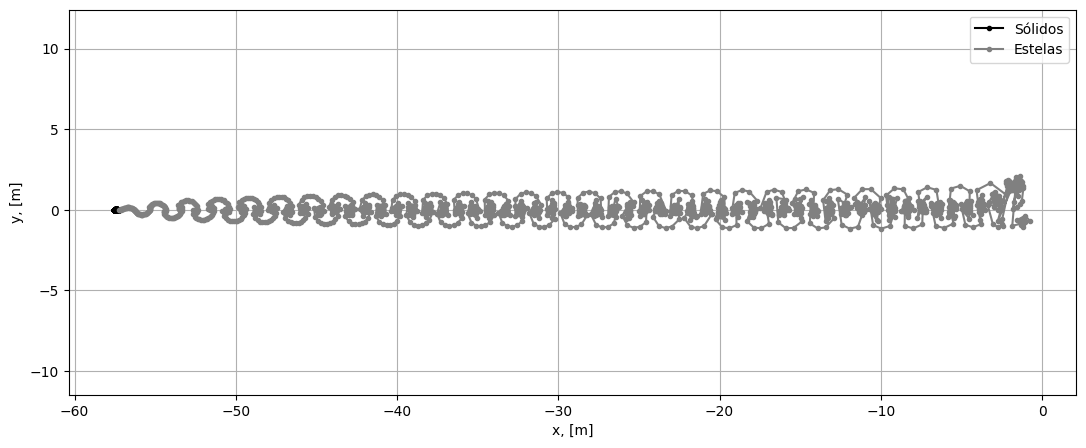

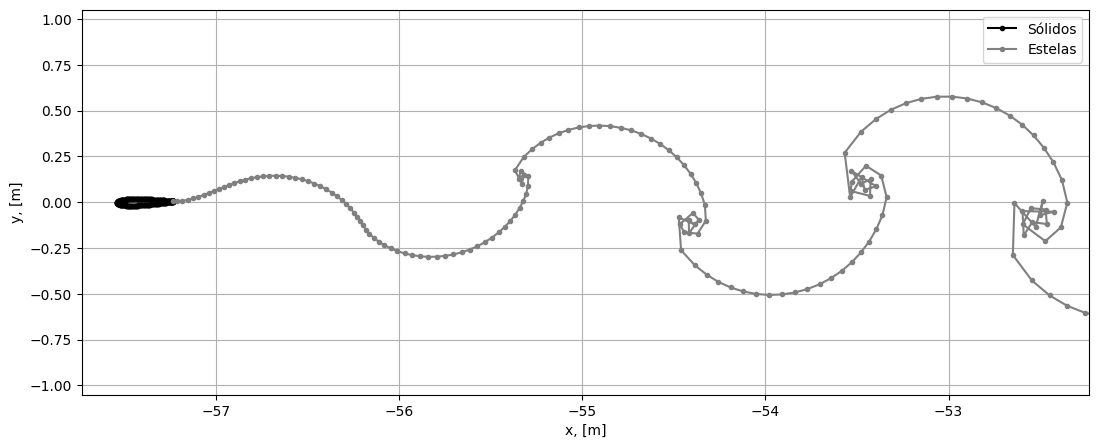

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
mp.plotPaneles(-1, ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(13, 5))
mp.plotPaneles(-1, ax=ax)
BF = mp.conjuntos[-1].solidos[0].r_xy[0, 0]
ax.set_xlim((BF - 0.5, BF + 5))
ax.set_ylim((-0.5, 0.5))

Aquí se puede ver cómo la oscilación del perfil produce cambios de circulación que originan el patrón típico de la estela en este tipo de experimentos.

También se puede ver que la discretización angular en este caso permite capturar estelas suaves, lo cual es crucial para resultados satisfactorios.

Se puede probar, variando la discretización, que el submuestreo afecta considerablemente los resultados, lo cual tiene sentido, pues las nuevas posiciones de las estelas se obtienen integrando las velocidades con Euler directo, lo que ocasiona que la estela convecte de forma más "rígida", alterando la respuesta en frecuencia.

El parámetro `rigidez` del simulador surgió por esto mismo. En algunas implementaciones no estacionarias, en lugar de hallar la nueva posición del nodo de la estela que se encuentra en el borde de fuga de un sólido en un instante dado integrando la velocidad en el borde de fuga, directamente se ubica en un punto entre la vieja posición del borde de fuga y la nueva, normalmente más cerca del último. Esto se inspira en la idea de que la vorticidad se genera en el borde de fuga y que por lo tanto la estela se teje en la traza del borde de fuga.

En la realidad ni una cosa ni la otra es cierta, ya que lo que suceda depende de la capa límite viscosa y de la frecuencia reducida del movimiento: a bajas frecuencias la estela se teje de forma más suave mientras que a altas la condición de Kutta se vulnera.

Entonces, el parámetro `rigidez`, como se puede consultar en la documentación, busca combinar ambos enfoques haciendo que las nuevas de los nodos en los bordes de fuga sean un promedio entre ambos enfoques.

En particular, en estos experimentos, simplemente se integra la velocidad.

## Número de condición y tiempo de simulación

Ya que en el caso estacionario se analizó el número de condición de la matriz de coeficientes, en este caso también. Por ejemplo, una incógnita que surge naturalmente es si podría evolucionar el número de condición con el número de iteración ya que cambia el número de paneles o por la formación de las estructuras de estela de forma periódica.

Frecuencia del movimiento armónico: 23.342724986811316


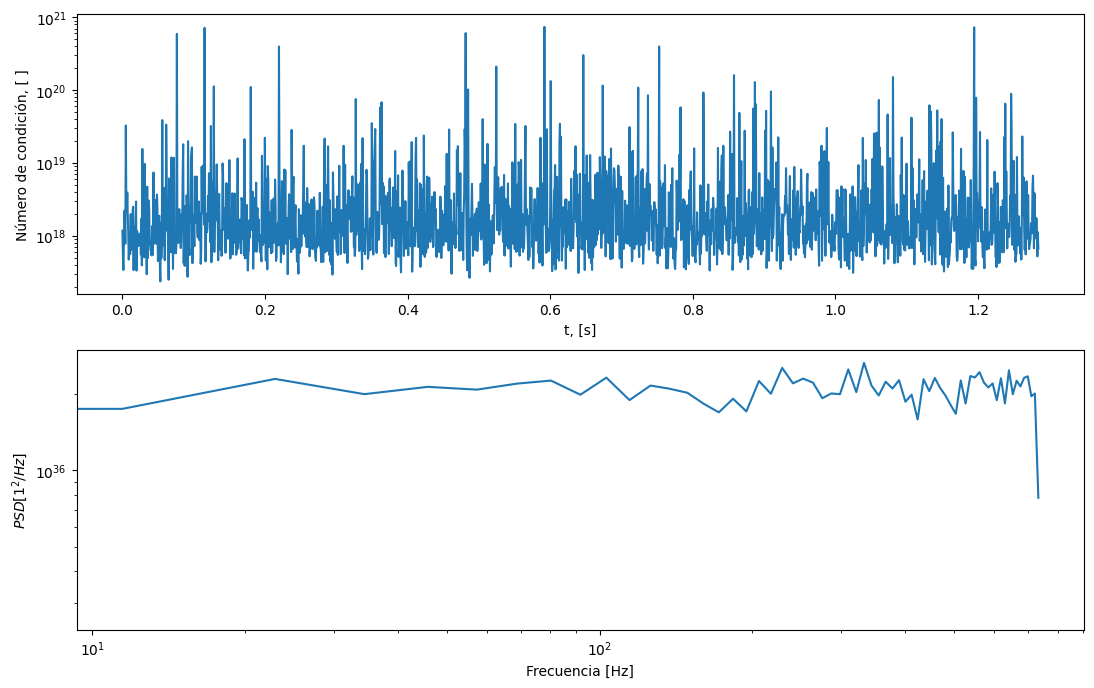

In [10]:
from scipy import signal
print(f'Frecuencia del movimiento armónico: {w / 2 / np.pi}')

Dt = mp.t[1] - mp.t[0]
f, Pxx = signal.welch(np.asarray(mp.SELInfo['nCond']), 1/Dt, nperseg=128)

fig, ax = plt.subplots(2, 1, figsize=(13, 8))
ax[0].semilogy(mp.t, mp.SELInfo['nCond'])

ax[0].set_xlabel('t, [s]')
ax[0].set_ylabel('Número de condición, [ ]')

ax[1].loglog(f, Pxx)
ax[1].set_xlabel('Frecuencia [Hz]')
ax[1].set_ylabel(r'$PSD [1^2/Hz]$')
plt.show()

En las figuras no se percibe ninguna evidente correlación entre el número de condición y el número de iteración o la frecuencia del movimiento armónico.

También se midieron los tiempos de resolución de cada instante y luego se calculó el tiempo de resolución acumulada desde el principio hasta cada paso.

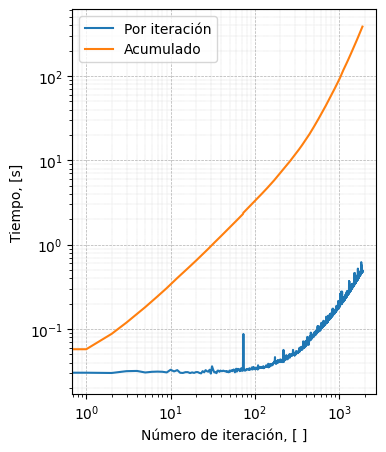

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
tAcum = np.cumsum(mp.tRes)
it = np.arange(len(mp.t))
ax.loglog(it, mp.tRes, label='Por iteración')
ax.loglog(it, tAcum, label='Acumulado')
ax.set_ylabel('Tiempo, [s]')
ax.set_xlabel('Número de iteración, [ ]')
ax.legend()

ax.grid(which='major', linestyle='--', linewidth=0.5)
ax.grid(which='minor', linestyle=':',  linewidth=0.3)
ax.minorticks_on()
ax.set_aspect('equal', 'box')


Se aprecia que inicialmente los tiempos son aproximadamente constantes, pero a medida que progresa la simulación la evolución del tiempo por iteración tiende a $O(i_t^2)$ y el acumulado a $O(i_t^3)$

## Resultados

Ahora sí se diseñan y simulan los experimentos llevados a cabo experimentalmente por NACA.

### Rotación

Simulando: 100%|██████████| 1885/1885 [06:12<00:00,  5.06 pasos/s]


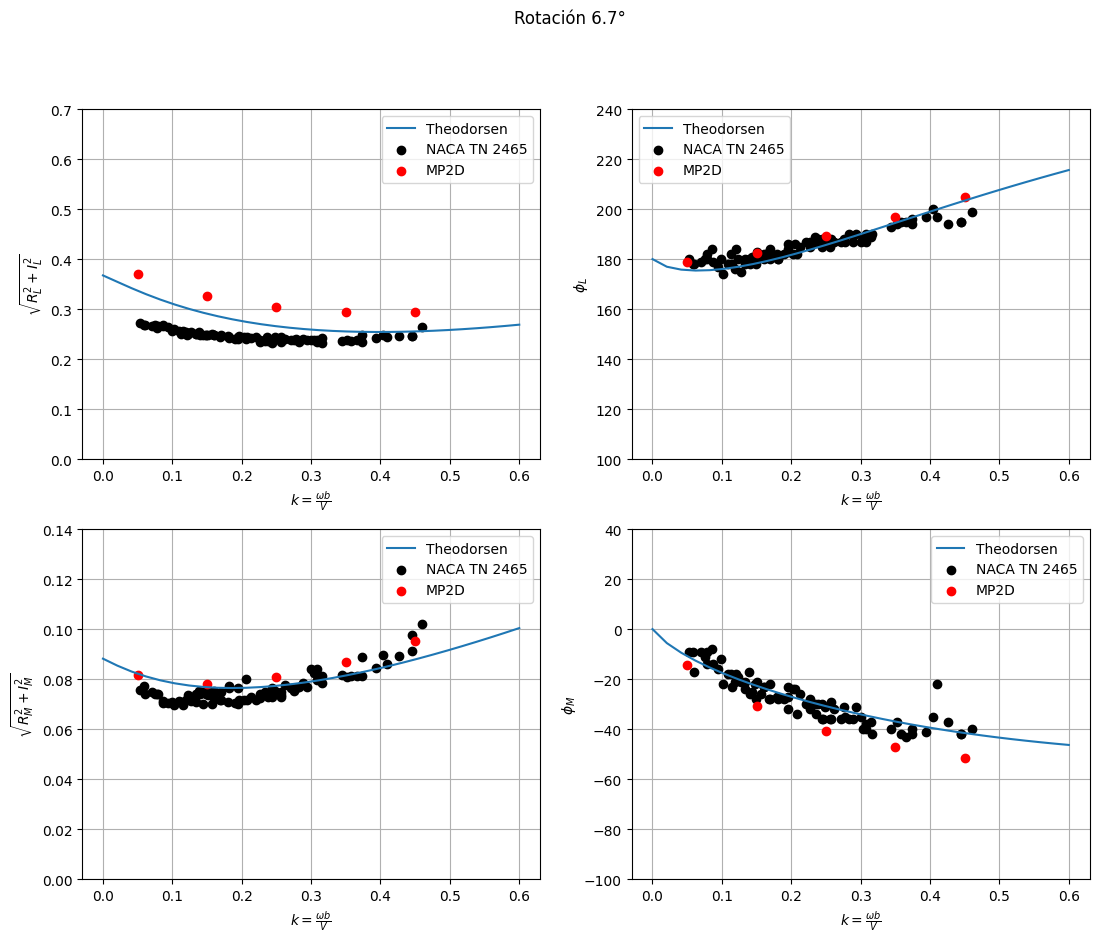

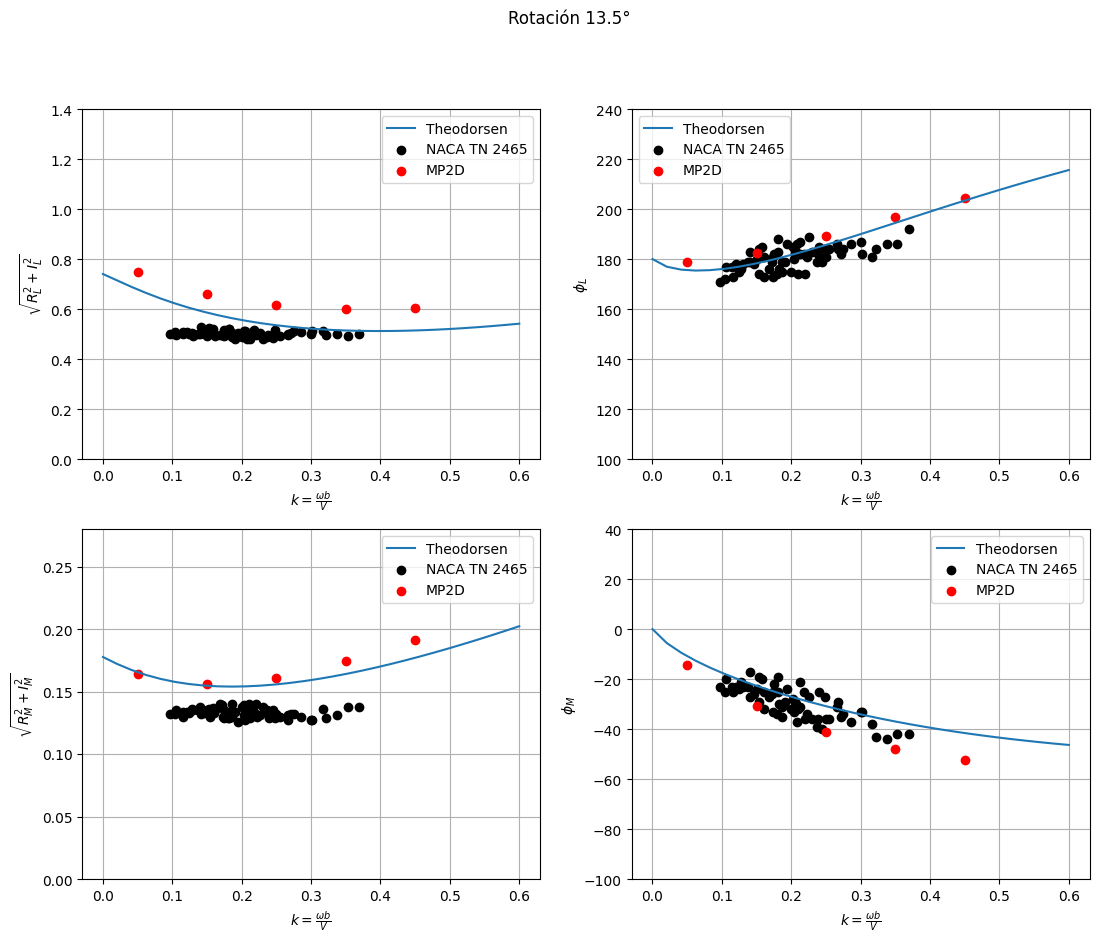

In [12]:
## 6.7
a0 = 6.7
LP, MP, _ = theodorsenRotacion(k, a0, c, c_rot, False)
LPSim, MPSim, _ = simulacionRotacion(kSim, a0)

fig, ax = plt.subplots(2, 2, figsize=(13, 10))
plotTeoricoExperimental(LP, MP, LPSim, MPSim, 'rec/NACATN2465/pitch 6.74.csv', [100, -100], f'Rotación {a0}°', fig, ax)

# Se hacen coincidir los ejes y de los plots con los de los gráficos del NACA TN 2465.
ax[0, 0].set_ylim([0, .7])
ax[0, 1].set_ylim([100, 240])
ax[1, 0].set_ylim([0, 0.14])
ax[1, 1].set_ylim([-100, 40])

## 13.5
a0 = 13.5
LP, MP, _ = theodorsenRotacion(k, a0, c, c_rot, False)
LPSim, MPSim, _ = simulacionRotacion(kSim, a0)

fig, ax = plt.subplots(2, 2, figsize=(13, 10))
plotTeoricoExperimental(LP, MP, LPSim, MPSim, 'rec/NACATN2465/pitch 13.48.csv', [100, -100], f'Rotación {a0}°', fig, ax)

# Se hacen coincidir los ejes y de los plots con los de los gráficos del NACA TN 2465.
ax[0, 0].set_ylim([0, 1.4])
ax[0, 1].set_ylim([100, 240])
ax[1, 0].set_ylim([0, 0.28])
ax[1, 1].set_ylim([-100, 40])

plt.show()

Los resultados son heterogéneos, pero en general es satisfactoria la coincidencia. Las mayores diferencias se encuentran en las curvas de amplitud de la sustentación, para ambas amplitudes de la rotación.

Brevemente, ya que esto se puede consultar en el NACA Report TN 2465, la curva teórica supone flujo potencial de una placa plana. Tanto las experiencias reales como las simuladas utilizan un perfil NACA 0012, con espesor. En la teoría potencial y en movimiento armónico de rotación, se predice que la amplitud de la sustentación aumenta con el espesor, lo cual ocurre en el método de los paneles pero no en los ensayos de túneles de viento. Estos menores valores obtenidos en los ensayos se atribuyen en la bibliografía a las pérdidas viscosas, pérdidas por tridimensionalidad remanente, a vibraciones y efectos elásticos de la estructura y el montaje, así como los errores propios de los instrumentos de calibración.

Sin embargo, el método de los paneles no está exento de introducir errores, como los propios errores numéricos de las sucesivas transformaciones de coordenadas, resolución del sistema de ecuaciones lineal, la integración numérica de las velocidades o incluso el número de períodos tomados y la estimación de la amplitud y fase de las señales.

Independientemente de si en estos experimentos en particular el método de los paneles no ofrece una predicción extremadamente acertada de la realidad, los resultados no fueron incongruentes ni con la teoría de placa plana ni con las experiencias de laboratorio.

### Traslación

Ahora veamos qué sucede con el movimiento armónico de traslación.

Simulando: 100%|██████████| 1885/1885 [06:10<00:00,  5.09 pasos/s]


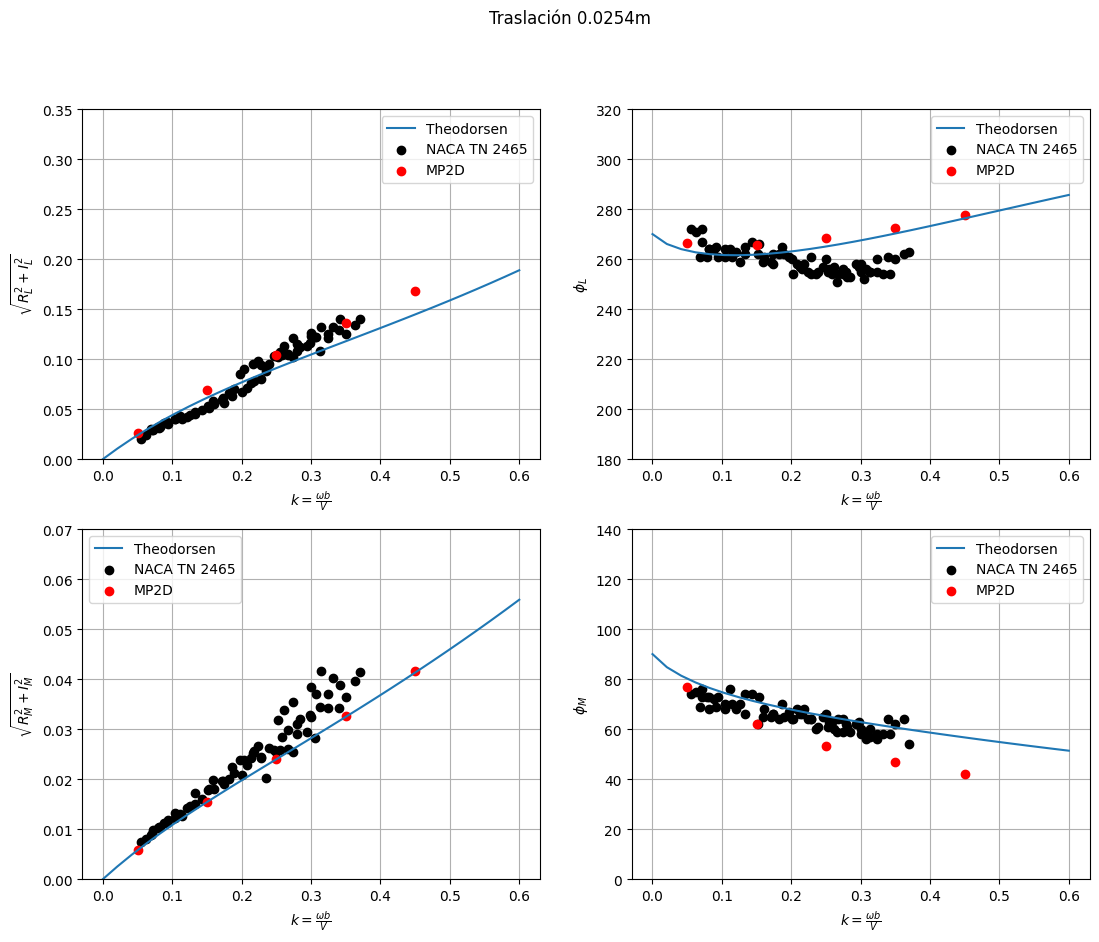

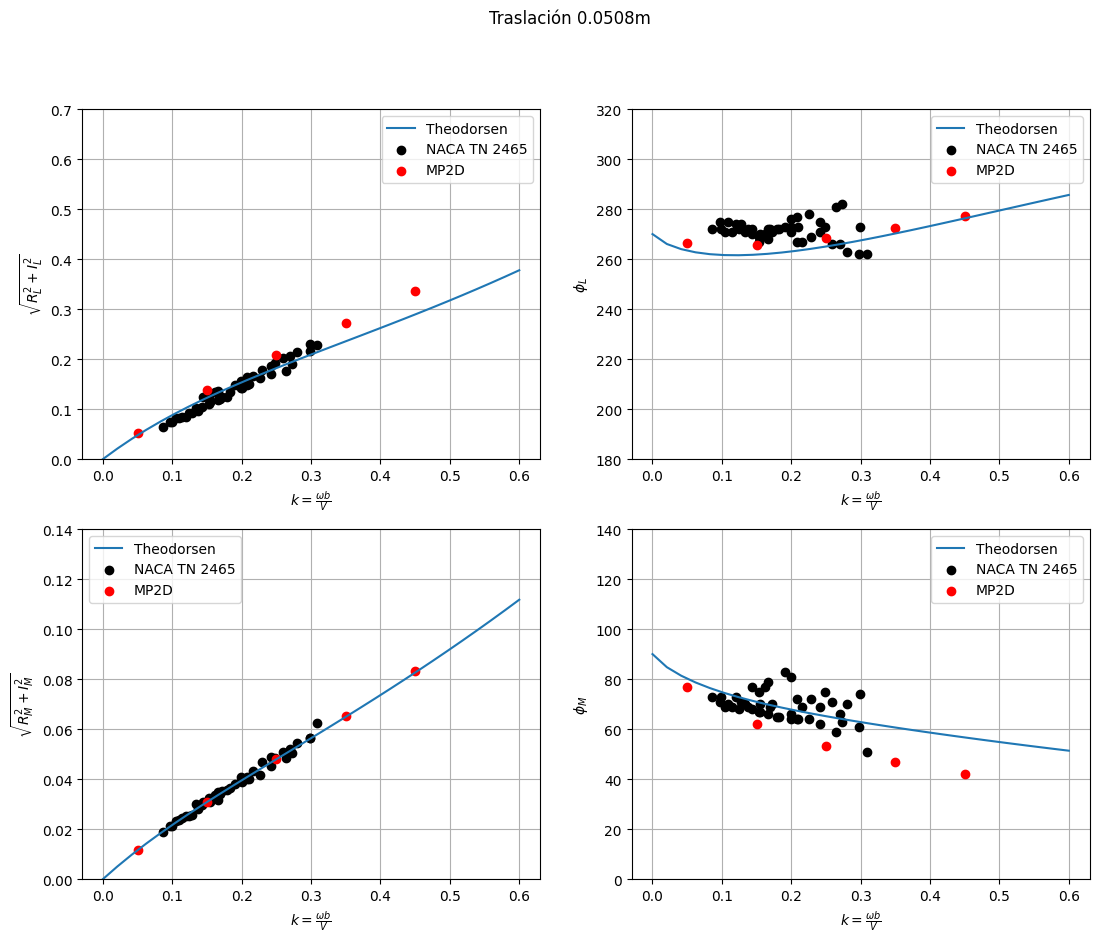

In [13]:
## 1
h0 = 1 * 0.0254
LT, MT, _ = theodorsenTraslacion(k, h0, c, c_rot, False)
LTSim, MTSim, _ = simulacionTraslacion(kSim, h0)

fig, ax = plt.subplots(2, 2, figsize=(13, 10))
plotTeoricoExperimental(LT, MT, LTSim, MTSim, 'rec/NACATN2465/translation 1.csv', [180, 0], f'Traslación {h0}m', fig, ax)

# Se hacen coincidir los ejes y de los plots con los de los gráficos del NACA TN 2465.
ax[0, 0].set_ylim([0, .35])
ax[0, 1].set_ylim([180, 320])
ax[1, 0].set_ylim([0, 0.07])
ax[1, 1].set_ylim([0, 140])

## 2
h0 = 2 * 0.0254
LT, MT, _ = theodorsenTraslacion(k, h0, c, c_rot, False)
LTSim, MTSim, _ = simulacionTraslacion(kSim, h0)

fig, ax = plt.subplots(2, 2, figsize=(13, 10))
plotTeoricoExperimental(LT, MT, LTSim, MTSim, 'rec/NACATN2465/translation 2 soft y stiff elements.csv', [180, 0], f'Traslación {h0}m', fig, ax)

# Se hacen coincidir los ejes y de los plots con los de los gráficos del NACA TN 2465.
ax[0, 0].set_ylim([0, .7])
ax[0, 1].set_ylim([180, 320])
ax[1, 0].set_ylim([0, 0.14])
ax[1, 1].set_ylim([0, 140])

plt.show()

En esta ocasión, las similitudes son mayores, sobre todo con la teoría de placa plana, aunque también con los ensayos, pues estos a su vez se asemejaron más a la teoría.

## Conclusión

El método de los paneles no predice de forma infalible la realidad. Esto era de esperarse dada su naturaleza no viscosa y la inherente falta de capacidad de captar efectos que se desarrollan a frecuencias reducidas cada vez más altas. Sin embargo, los resultados obtenidos se consideran satisfactorios desde el punto de vista de validación de la implementación en su esquema no estacionario y sugieren que podría ser utilizado para otro tipo de movimientos, siempre teniendo en cuenta el grado de validez de las hipótesis en el problema particular que se estudie y que el método proporciona una estimación, normalmente más favorable en términos de eficiencia aerodinámica que la realidad.